# Testing isostatic boundary conditions in UW2

This is a check to make sure UW2's pressure boundary condition properly works.

The setup is:

     <--------- 100 km ------------>
    _________________________________
    |                               |  ^
    |                               |  |
    |     compressible air          |  50 km 
    |        1 kg.m^-3              |  |
    |                               |  | 
    |_______________________________|  v 
    |        crust                  |  ^ 
    |        500 kg.m^-3            |  25 km 
    |_______________________________|  v 
    |        mantle                 |  ^ 
    |        1000 kg.m^-3           |  25 km 
    |_______________________________|  v 

We pull each vertical wall at 1 cm/yr (total extension is 2 cm/yr)
The top wall has a free slip boundary (no air can flow in or out of the top)
The bottom wall as a pressure boundary condition

If we pull long enough, we expect the crust material to thin to essentially
0 thickness, and that the surface will subside by some amount. 

Analytically, assuming the crust thickness has been thinned to 0, we get this 
formula to calculate the subsidence:

    h = ( rho_crust * a - rho_mantle * a ) / ( rho_air - rho_mantle )

where h is the subsidence amount, and a is the original thickness of the crust layer.

This calculation comes out to ~12.5 km of subsidence. If you run this model, you will
see the approximately same answer! Hooray!

Note: the model does encounter some velocity instabilities, but broadly seems to be correct.
With higher resolution, or smaller timesteps, it might be happier

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import numpy as np
import matplotlib.pyplot as plt

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
GEO.rcParams['solver'] = "mumps"
GEO.rcParams["surface.pressure.normalization"] = True

# must be 0, because we use compressible air
GEO.rcParams["penalty"] = 0

# Use some higher order elements to get a nicer solution
GEO.rcParams["element.type"] = "Q2/dQ1"

# Use the fancier advection diffusion method
GEO.rcParams["advection.diffusion.method"] = "SLCN"

# Normally this is 0.5, but it can make it easier for the solver if you reduce this number.
GEO.rcParams["CFL"] = 0.25

# Adjust how particles populate the model. Because this model has a big load of inflowing material,
# I like to have these very aggressive
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60
GEO.rcParams["swarm.particles.per.cell.2D"] = 60

In [3]:
GEO.rcParams["output.directory"] = "simple_isos_1"

In [4]:
# This is all for scaling the model
# most of it is pretty self explanitory, try to make them match your setup as best as possible
half_rate = 1.0 * u.centimeter / u.year
model_length = 100e3 * u.meter
model_height = 100e3 * u.meter
refViscosity = 1e22 * u.pascal * u.second
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
# Setup the model domain and resolution. The 'divisor' is just an easy way to adjust the resolution
divisor = 4
Model = GEO.Model(elementRes=(int(100/divisor),int(100/divisor)), 
                  minCoord=(-50 * u.kilometer, -50 * u.kilometer),
                  maxCoord=( 50 * u.kilometer,  50 * u.kilometer))

In [6]:
air = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
uc =  Model.add_material(name="crust",  shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-25*u.kilometer))
mantle = Model.add_material(name="mantle",  shape=GEO.shapes.Layer2D(top=uc.bottom, bottom=Model.bottom))

# We use 'easy' numbers here, so the analytical calculation is easier.
air.density    =    1. * u.kilogram / u.metre**3
uc.density     =  500. * u.kilogram / u.metre**3
mantle.density = 1000. * u.kilogram / u.metre**3


air.viscosity    = 1e19 * u.pascal * u.second
uc.viscosity     = 1e21 * u.pascal * u.second  # If you make everything the same viscosity, UW goes a bit wild, so 
mantle.viscosity = 1e20 * u.pascal * u.second  # by making these different, it gives the solver something to 'do'.


# we need to make the air compressible, so we can put a no infow boundary condition on the top of the model
air.compressibility = 1e3  # Not sure what's a good value

In [7]:
# We need to initialise the model before calculating anything to serious (like the lithostatic pressure)
Model.init_model()

# This is where isostasy is imposed. We first calculate the lithostatic pressure along the entire bottom of the model. 
P, bottomPress = Model.get_lithostatic_pressureField()

# Then, since the model is laterally homogenous, we average it, and put it into megapascals
bottomPress = GEO.Dimensionalize(np.average(bottomPress), u.megapascal)


# This is where we apply the boundary conditions. As a rule of thumb, the more information we can give to UW, the happier
# it will be. For example, we could make the top a free slip condition:
#     top=[None , 0. * u.centimetre / u.year]
# but really, we don't care much about the top of the air, so giving 'extra info' in the form of a no-slip condition
# helps UW figure out what's going on.
# Try removing various bits of information to compare how the model performs.
Model.set_velocityBCs(left   = [-1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      right  = [1.0 * u.centimetre / u.year,  0 * u.centimetre / u.year], 
                      top    = [0 * u.centimetre / u.year,    0. * u.centimetre / u.year], 
                      bottom = [None,                         bottomPress]) # This is where the pressure boundary is applied.

In [8]:
# Here we setup a passive tracer - just one particle, right at the top of the crust, right in the middle of the
# model. Hopefully it won't advect too much in either direction, but really we only care about its height.
mswarm = uw.swarm.Swarm( mesh=Model.mesh, particleEscape=True )
msAdvector= uw.systems.SwarmAdvector(Model.velocityField, mswarm, order=4)

height_through_time = []

particleCoordinates = np.zeros((1,2))
particleCoordinates[:,0] = 0
particleCoordinates[:,1] = 0
_ = mswarm.add_particles_with_coordinates(particleCoordinates)

# Here we have to tell UWGeodynamics that we have some extra work to do at the end of each solve
def advect_passive():
    msAdvector.integrate(Model._dt)
    height_through_time.append((Model.time.magnitude, GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer).magnitude))
    #mswarm.[:,0] = 0  # reset back to centre - not sure how to do this.
Model.postSolveHook = advect_passive

In [9]:
# This is a bunch of solver options. You can try playing with them, but these should be good enough.
Model.solver = Model.stokes_solver()
Model.solver.options.A11.ksp_rtol=1e-8
Model.solver.options.scr.ksp_rtol=1e-8
Model.solver.options.scr.use_previous_guess = True
Model.solver.options.scr.ksp_set_min_it_converge = 10
Model.solver.options.scr.ksp_type = "cg"
Model.solver.options.main.remove_constant_pressure_null_space=True


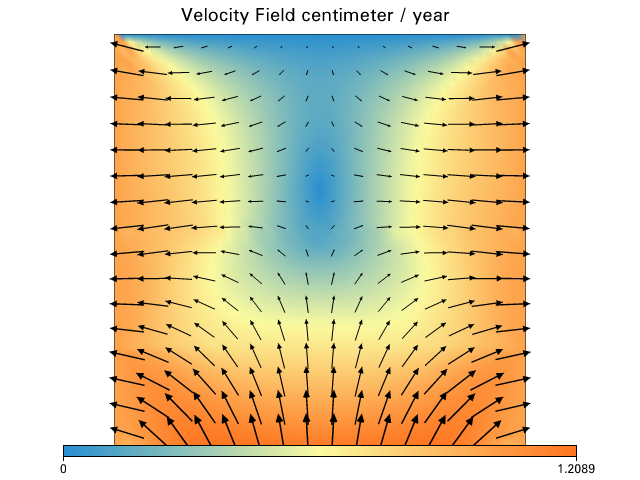


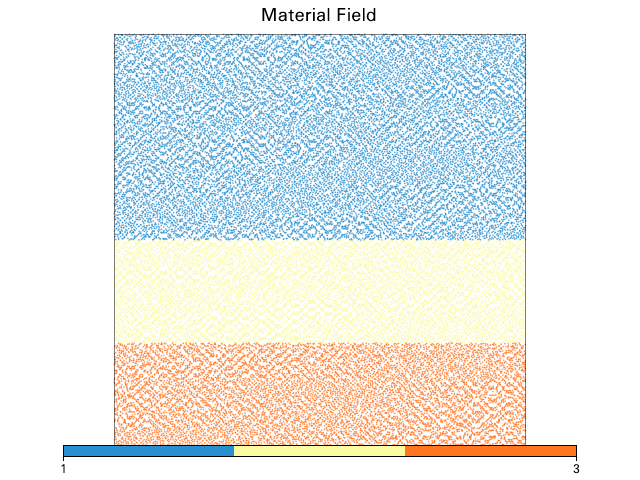

In [10]:
# Do an initial solve to give us a look at what's happening.
Model.solve()
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

## Run model for 5 Myr increments, and show the results

In [11]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  20679.557625719746 year dt: 20679.55762571975 year (2018-10-25 03:53:55)
Step:2 Model Time:  43943.40074168378 year dt: 23263.84311596403 year (2018-10-25 03:53:55)
Step:3 Model Time:  67209.0556733655 year dt: 23265.654931681718 year (2018-10-25 03:53:56)
Step:4 Model Time:  90082.27591912319 year dt: 22873.220245757686 year (2018-10-25 03:53:56)
Step:5 Model Time:  112426.72141525763 year dt: 22344.445496134453 year (2018-10-25 03:53:56)
Step:6 Model Time:  134021.43179826258 year dt: 21594.710383004964 year (2018-10-25 03:53:57)
Step:7 Model Time:  156217.64293443048 year dt: 22196.211136167884 year (2018-10-25 03:53:57)
Step:8 Model Time:  178091.4701249335 year dt: 21873.827190503023 year (2018-10-25 03:53:57)
Step:9 Model Time:  200370.89130500585 year dt: 22279.42118007236 year (2018-10-25 03:53:58)
Step:10 Model Time:  223827.01487210652 year dt: 23456.123567100658 year (2018-10-25 03:53:58)
S

Step:88 Model Time:  2086164.6126673475 year dt: 24196.48025904556 year (2018-10-25 03:54:25)
Step:89 Model Time:  2108096.8577442016 year dt: 21932.245076853822 year (2018-10-25 03:54:26)
Step:90 Model Time:  2131950.1846079226 year dt: 23853.32686372082 year (2018-10-25 03:54:26)
Step:91 Model Time:  2155968.0349546233 year dt: 24017.850346700936 year (2018-10-25 03:54:27)
Step:92 Model Time:  2180097.6139250468 year dt: 24129.57897042323 year (2018-10-25 03:54:27)
Step:93 Model Time:  2204123.384684689 year dt: 24025.770759642175 year (2018-10-25 03:54:27)
Step:94 Model Time:  2228605.138558448 year dt: 24481.753873758775 year (2018-10-25 03:54:28)
Step:95 Model Time:  2253110.3932811557 year dt: 24505.25472270789 year (2018-10-25 03:54:28)
Step:96 Model Time:  2277618.5066774017 year dt: 24508.11339624633 year (2018-10-25 03:54:28)
Step:97 Model Time:  2302072.31233113 year dt: 24453.805653728075 year (2018-10-25 03:54:29)
Step:98 Model Time:  2326756.0527191665 year dt: 24683.7403

Step:175 Model Time:  4186771.302977854 year dt: 22418.02181471242 year (2018-10-25 03:54:57)
Step:176 Model Time:  4210618.714975703 year dt: 23847.411997849515 year (2018-10-25 03:54:57)
Step:177 Model Time:  4235405.071741753 year dt: 24786.35676605054 year (2018-10-25 03:54:58)
Step:178 Model Time:  4259954.288081771 year dt: 24549.21634001766 year (2018-10-25 03:54:58)
Step:179 Model Time:  4284623.983723115 year dt: 24669.69564134438 year (2018-10-25 03:54:58)
Step:180 Model Time:  4308727.878348369 year dt: 24103.894625253983 year (2018-10-25 03:54:59)
Step:181 Model Time:  4333072.053065312 year dt: 24344.174716942278 year (2018-10-25 03:54:59)
Step:182 Model Time:  4357327.971283609 year dt: 24255.91821829667 year (2018-10-25 03:54:59)
Step:183 Model Time:  4382118.704350495 year dt: 24790.733066885346 year (2018-10-25 03:55:00)
Step:184 Model Time:  4405035.204246749 year dt: 22916.49989625419 year (2018-10-25 03:55:00)
Step:185 Model Time:  4429859.135370934 year dt: 24823.9

1


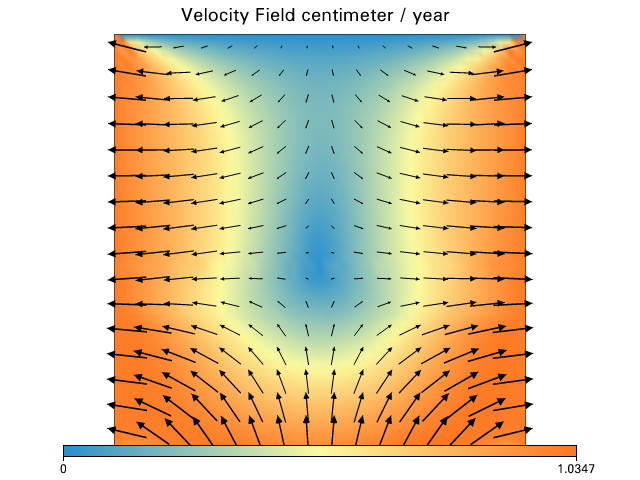


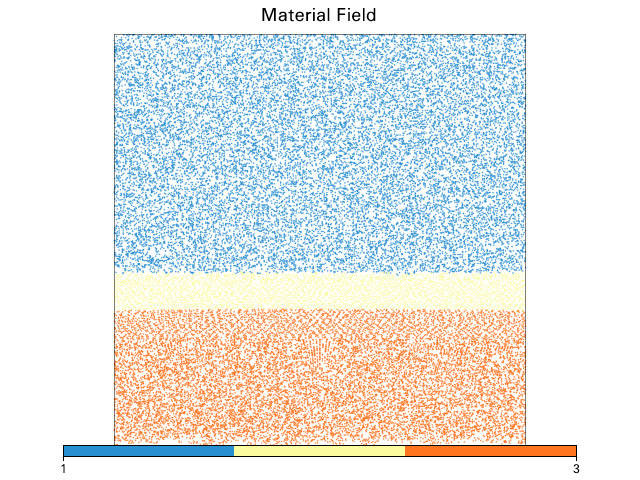

Text(0.5,1,'Subsidence of surface during thinning')

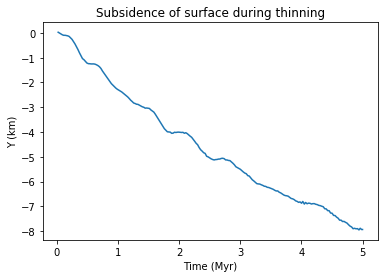

In [12]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [13]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  5024459.927805987 year dt: 24459.9278059862 year (2018-10-25 03:55:11)
Step:2 Model Time:  5049337.113795378 year dt: 24877.185989390644 year (2018-10-25 03:55:12)
Step:3 Model Time:  5073809.17900671 year dt: 24472.065211331825 year (2018-10-25 03:55:12)
Step:4 Model Time:  5096948.123832431 year dt: 23138.944825720857 year (2018-10-25 03:55:13)
Step:5 Model Time:  5121577.394419083 year dt: 24629.2705866529 year (2018-10-25 03:55:13)
Step:6 Model Time:  5146089.060913771 year dt: 24511.666494688154 year (2018-10-25 03:55:13)
Step:7 Model Time:  5170008.4538546875 year dt: 23919.39294091594 year (2018-10-25 03:55:14)
Step:8 Model Time:  5193243.609801397 year dt: 23235.15594670916 year (2018-10-25 03:55:14)
Step:9 Model Time:  5216724.184364285 year dt: 23480.574562889266 year (2018-10-25 03:55:14)
Step:10 Model Time:  5241456.675131773 year dt: 24732.490767487263 year (2018-10-25 03:55:15)
Step:11 M

Step:88 Model Time:  7072381.026485478 year dt: 24736.482433150275 year (2018-10-25 03:55:43)
Step:89 Model Time:  7093649.070078444 year dt: 21268.043592965474 year (2018-10-25 03:55:43)
Step:90 Model Time:  7118510.777385206 year dt: 24861.707306762422 year (2018-10-25 03:55:44)
Step:91 Model Time:  7140918.137948566 year dt: 22407.360563360722 year (2018-10-25 03:55:44)
Step:92 Model Time:  7165256.394996354 year dt: 24338.257047787883 year (2018-10-25 03:55:44)
Step:93 Model Time:  7190083.823692166 year dt: 24827.428695811985 year (2018-10-25 03:55:45)
Step:94 Model Time:  7214415.257467801 year dt: 24331.433775633926 year (2018-10-25 03:55:45)
Step:95 Model Time:  7238584.723085192 year dt: 24169.46561739116 year (2018-10-25 03:55:45)
Step:96 Model Time:  7259457.388155032 year dt: 20872.66506983991 year (2018-10-25 03:55:46)
Step:97 Model Time:  7283139.347534909 year dt: 23681.959379876913 year (2018-10-25 03:55:46)
Step:98 Model Time:  7307894.571139283 year dt: 24755.22360437

Step:175 Model Time:  9159898.523203187 year dt: 24849.145527399603 year (2018-10-25 03:56:14)
Step:176 Model Time:  9182604.476194154 year dt: 22705.952990968522 year (2018-10-25 03:56:14)
Step:177 Model Time:  9207530.17195326 year dt: 24925.69575910646 year (2018-10-25 03:56:14)
Step:178 Model Time:  9232435.109110573 year dt: 24904.93715731206 year (2018-10-25 03:56:15)
Step:179 Model Time:  9257208.344464598 year dt: 24773.235354023254 year (2018-10-25 03:56:15)
Step:180 Model Time:  9281877.117955318 year dt: 24668.773490721007 year (2018-10-25 03:56:16)
Step:181 Model Time:  9306803.657401128 year dt: 24926.539445810424 year (2018-10-25 03:56:16)
Step:182 Model Time:  9331701.119578522 year dt: 24897.4621773949 year (2018-10-25 03:56:16)
Step:183 Model Time:  9356547.747376166 year dt: 24846.627797644505 year (2018-10-25 03:56:17)
Step:184 Model Time:  9381430.61623048 year dt: 24882.868854312383 year (2018-10-25 03:56:17)
Step:185 Model Time:  9406385.265261747 year dt: 24954.6

1


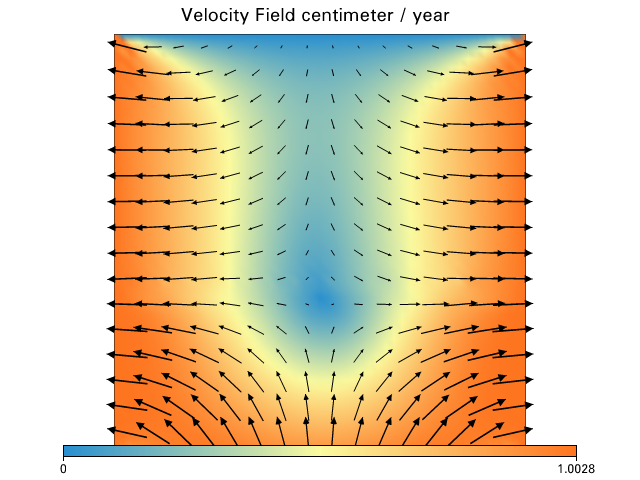


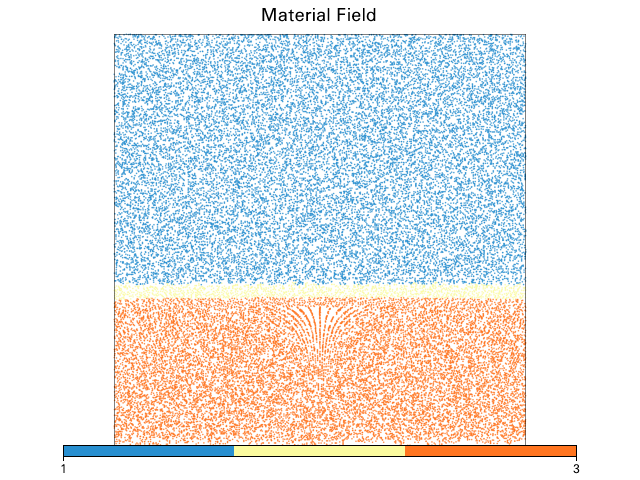

Text(0.5,1,'Subsidence of surface during thinning')

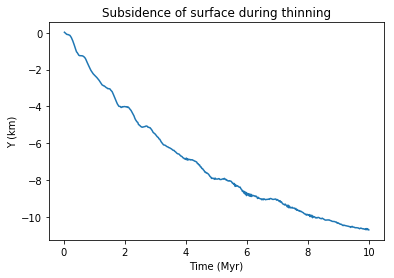

In [14]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [15]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  10024801.324849747 year dt: 24801.324849751883 year (2018-10-25 03:56:28)
Step:2 Model Time:  10049710.731401417 year dt: 24909.40655166905 year (2018-10-25 03:56:29)
Step:3 Model Time:  10072279.334981523 year dt: 22568.603580107036 year (2018-10-25 03:56:29)
Step:4 Model Time:  10096305.104611473 year dt: 24025.769629948532 year (2018-10-25 03:56:30)
Step:5 Model Time:  10121177.732272582 year dt: 24872.62766110845 year (2018-10-25 03:56:30)
Step:6 Model Time:  10144669.022263791 year dt: 23491.289991209487 year (2018-10-25 03:56:30)
Step:7 Model Time:  10169583.772160718 year dt: 24914.74989692822 year (2018-10-25 03:56:31)
Step:8 Model Time:  10193456.73585633 year dt: 23872.9636956116 year (2018-10-25 03:56:31)
Step:9 Model Time:  10216657.482233187 year dt: 23200.74637685641 year (2018-10-25 03:56:31)
Step:10 Model Time:  10241580.416043818 year dt: 24922.9338106332 year (2018-10-25 03:56:32)
St

Step:88 Model Time:  12095064.129078178 year dt: 21628.669342425637 year (2018-10-25 03:57:00)
Step:89 Model Time:  12120064.129078178 year dt: 24999.999999999884 year (2018-10-25 03:57:00)
Step:90 Model Time:  12141566.948398149 year dt: 21502.819319969192 year (2018-10-25 03:57:01)
Step:91 Model Time:  12165377.866023457 year dt: 23810.917625308346 year (2018-10-25 03:57:01)
Step:92 Model Time:  12187569.618586319 year dt: 22191.752562861595 year (2018-10-25 03:57:01)
Step:93 Model Time:  12212569.618586319 year dt: 24999.999999999884 year (2018-10-25 03:57:02)
Step:94 Model Time:  12235950.383337608 year dt: 23380.76475128972 year (2018-10-25 03:57:02)
Step:95 Model Time:  12260866.8681607 year dt: 24916.4848230923 year (2018-10-25 03:57:02)
Step:96 Model Time:  12285116.33042775 year dt: 24249.462267049414 year (2018-10-25 03:57:03)
Step:97 Model Time:  12310067.146392958 year dt: 24950.815965209225 year (2018-10-25 03:57:03)
Step:98 Model Time:  12332267.48474701 year dt: 22200.33

Step:175 Model Time:  14145908.015300889 year dt: 24919.69562415134 year (2018-10-25 03:57:31)
Step:176 Model Time:  14167812.628865529 year dt: 21904.613564639534 year (2018-10-25 03:57:31)
Step:177 Model Time:  14192787.546449903 year dt: 24974.917584375136 year (2018-10-25 03:57:32)
Step:178 Model Time:  14215164.081528857 year dt: 22376.535078954512 year (2018-10-25 03:57:32)
Step:179 Model Time:  14240164.08152886 year dt: 24999.999999999884 year (2018-10-25 03:57:33)
Step:180 Model Time:  14256659.381282408 year dt: 16495.299753549356 year (2018-10-25 03:57:33)
Step:181 Model Time:  14281659.381282408 year dt: 24999.999999999884 year (2018-10-25 03:57:33)
Step:182 Model Time:  14300722.84720754 year dt: 19063.465925132732 year (2018-10-25 03:57:34)
Step:183 Model Time:  14325713.351291925 year dt: 24990.504084383516 year (2018-10-25 03:57:34)
Step:184 Model Time:  14348132.22616209 year dt: 22418.87487016721 year (2018-10-25 03:57:34)
Step:185 Model Time:  14373090.388011152 year

1


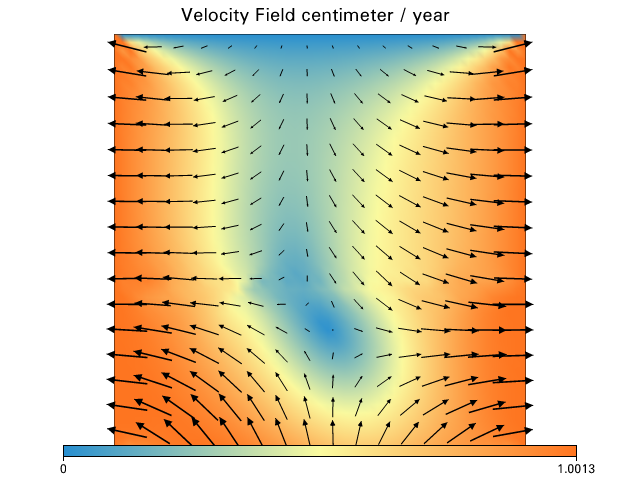


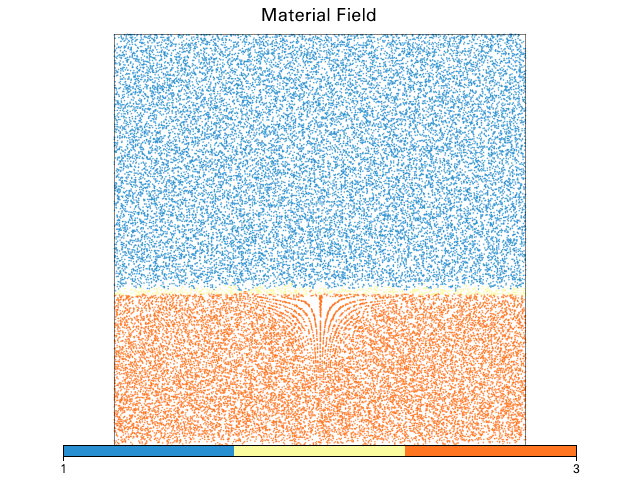

Text(0.5,1,'Subsidence of surface during thinning')

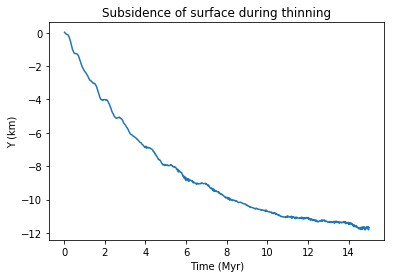

In [16]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [17]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  15023141.205793547 year dt: 23141.205793552264 year (2018-10-25 03:57:48)
Step:2 Model Time:  15048141.205793547 year dt: 24999.999999999884 year (2018-10-25 03:57:48)
Step:3 Model Time:  15064118.519170895 year dt: 15977.31337734868 year (2018-10-25 03:57:49)
Step:4 Model Time:  15089061.845246444 year dt: 24943.326075546618 year (2018-10-25 03:57:49)
Step:5 Model Time:  15106108.242368046 year dt: 17046.39712160434 year (2018-10-25 03:57:49)
Step:6 Model Time:  15131004.512015931 year dt: 24896.269647884143 year (2018-10-25 03:57:50)
Step:7 Model Time:  15146718.542962825 year dt: 15714.030946893079 year (2018-10-25 03:57:50)
Step:8 Model Time:  15171717.30798314 year dt: 24998.765020316416 year (2018-10-25 03:57:50)
Step:9 Model Time:  15191083.652980976 year dt: 19366.344997834185 year (2018-10-25 03:57:51)
Step:10 Model Time:  15215945.842820413 year dt: 24862.189839438488 year (2018-10-25 03:57:

Step:88 Model Time:  16894649.774606008 year dt: 20515.485710935296 year (2018-10-25 03:58:19)
Step:89 Model Time:  16919645.851428177 year dt: 24996.0768221684 year (2018-10-25 03:58:19)
Step:90 Model Time:  16938676.170380253 year dt: 19030.318952077123 year (2018-10-25 03:58:20)
Step:91 Model Time:  16963603.950875115 year dt: 24927.780494859333 year (2018-10-25 03:58:20)
Step:92 Model Time:  16986842.002689432 year dt: 23238.051814317958 year (2018-10-25 03:58:21)
Step:93 Model Time:  17011759.639183834 year dt: 24917.636494399234 year (2018-10-25 03:58:21)
Step:94 Model Time:  17025163.07180504 year dt: 13403.432621210299 year (2018-10-25 03:58:21)
Step:95 Model Time:  17050163.07180504 year dt: 24999.999999999884 year (2018-10-25 03:58:22)
Step:96 Model Time:  17065202.34656904 year dt: 15039.274763995169 year (2018-10-25 03:58:22)
Step:97 Model Time:  17089890.14027593 year dt: 24687.79370689397 year (2018-10-25 03:58:22)
Step:98 Model Time:  17106188.434901647 year dt: 16298.29

Step:175 Model Time:  18824614.39810329 year dt: 14128.066903148188 year (2018-10-25 03:58:50)
Step:176 Model Time:  18849461.58469746 year dt: 24847.186594168656 year (2018-10-25 03:58:50)
Step:177 Model Time:  18863622.723441374 year dt: 14161.138743915906 year (2018-10-25 03:58:51)
Step:178 Model Time:  18888622.723441374 year dt: 24999.999999999884 year (2018-10-25 03:58:51)
Step:179 Model Time:  18906919.086863272 year dt: 18296.363421899998 year (2018-10-25 03:58:51)
Step:180 Model Time:  18931688.18459294 year dt: 24769.09772966733 year (2018-10-25 03:58:52)
Step:181 Model Time:  18944855.104087453 year dt: 13166.919494512034 year (2018-10-25 03:58:52)
Step:182 Model Time:  18969824.862195052 year dt: 24969.758107603022 year (2018-10-25 03:58:52)
Step:183 Model Time:  18980947.939838894 year dt: 11123.07764384258 year (2018-10-25 03:58:53)
Step:184 Model Time:  19005916.938456994 year dt: 24968.998618098438 year (2018-10-25 03:58:53)
Step:185 Model Time:  19020733.341103572 year

1


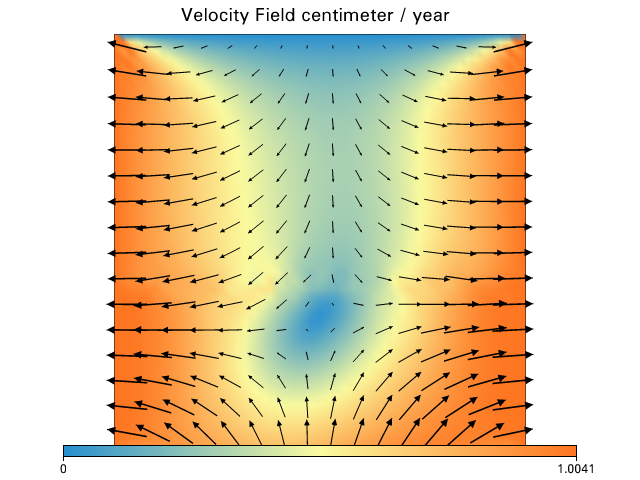


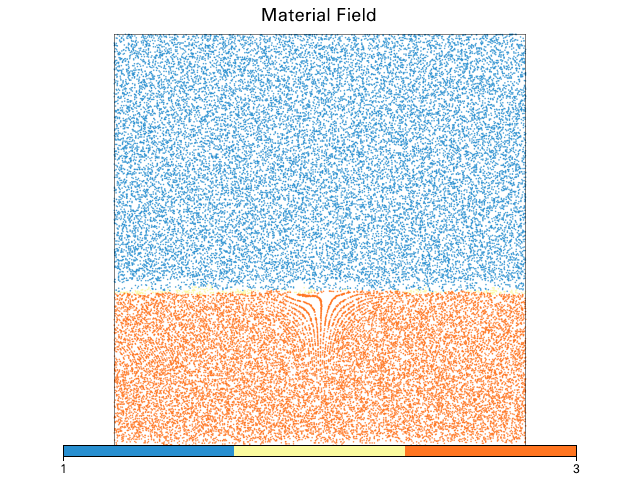

Text(0.5,1,'Subsidence of surface during thinning')

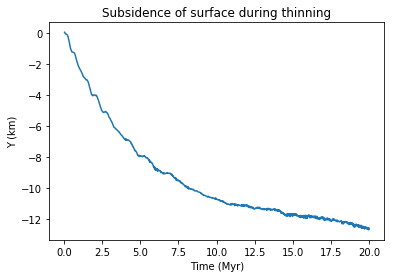

In [18]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

# Summary

While things get a bit unstable at the end, we can see that the model tends towards the answer we predicted analytically, which is good!

In [30]:
a = uc.bottom - uc.top
expected_subsidence = ( (500 * u.kilogram / u.metre**3) * a - (1000  * u.kilogram / u.metre**3) * a) / ( (1 * u.kilogram / u.metre**3) - (1000 * u.kilogram / u.metre**3) )
print("Expected subsidence: ", expected_subsidence)
print("Modelled subsidence: ", GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer))
print("The passive tracer also advected laterally from x = 0 to x = {}".format(GEO.Dimensionalize(mswarm.particleCoordinates.data[:,0].copy()[0], u.kilometer)))

Expected subsidence:  -12.512512512512513 kilometer
Modelled subsidence:  -12.554680630287042 kilometer
The passive tracer also advected laterally from x = 0 to x = -20.381232682119062 kilometer
